# 5. Cross-Survey GRI Comparison

This notebook compares GRI scores across different Global Dialogues surveys to understand how representativeness varies over time and between different survey methodologies.

## Overview

We compare GRI performance across:
- **GD1**: First Global Dialogues survey (1,278 participants, 75 countries)
- **GD2**: Second Global Dialogues survey (1,104 participants, 65 countries)
- **GD3**: Third Global Dialogues survey (970 participants, 63 countries)

This analysis helps identify:
1. Trends in survey representativeness over time
2. Dimensional strengths and weaknesses across surveys
3. Comparative performance metrics
4. Best practices for future survey design

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import json
import os

# Add the gri module to the path
sys.path.append('..')
from gri.calculator import calculate_gri, calculate_diversity_score
from gri.utils import load_data

# Set plotting style
plt.style.use('default')
sns.set_palette('Set2')

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## 1. Load Survey Data and Calculate GRI Scores

In [2]:
# Load benchmark data
benchmark_age_gender = load_data('../data/processed/benchmark_country_gender_age.csv')
benchmark_religion = load_data('../data/processed/benchmark_country_religion.csv')
benchmark_environment = load_data('../data/processed/benchmark_country_environment.csv')

# Load all GD survey datasets
surveys = {
    'GD1': load_data('../data/processed/gd1_demographics.csv'),
    'GD2': load_data('../data/processed/gd2_demographics.csv'),
    'GD3': load_data('../data/processed/gd3_demographics.csv')
}

print("Global Dialogues Survey Data Summary:")
print("=" * 50)
for survey_name, data in surveys.items():
    print(f"{survey_name}: {len(data):,} participants, {data['country'].nunique()} countries")
    top_countries = list(data['country'].value_counts().head(3).index)
    print(f"  Top countries: {', '.join(top_countries)}")
    print()

Global Dialogues Survey Data Summary:
GD1: 1,278 participants, 75 countries
  Top countries: India, Kenya, United States

GD2: 1,104 participants, 65 countries
  Top countries: India, Kenya, United States

GD3: 970 participants, 63 countries
  Top countries: India, Kenya, China



In [3]:
# Calculate GRI scores for all surveys and dimensions
dimensions = {
    'Country × Gender × Age': {
        'benchmark': benchmark_age_gender,
        'strata_cols': ['country', 'gender', 'age_group']
    },
    'Country × Religion': {
        'benchmark': benchmark_religion,
        'strata_cols': ['country', 'religion']
    },
    'Country × Environment': {
        'benchmark': benchmark_environment,
        'strata_cols': ['country', 'environment']
    }
}

# Calculate scores for all survey-dimension combinations
results = []

print("Calculating GRI and Diversity Scores...")
print("=" * 50)

for survey_name, survey_data in surveys.items():
    print(f"\n{survey_name} ({len(survey_data):,} participants):")
    
    survey_results = {
        'survey': survey_name,
        'participants': len(survey_data),
        'countries': survey_data['country'].nunique()
    }
    
    for dim_name, dim_config in dimensions.items():
        # Calculate GRI and Diversity scores
        gri_score = calculate_gri(
            survey_data, 
            dim_config['benchmark'], 
            dim_config['strata_cols']
        )
        
        diversity_score = calculate_diversity_score(
            survey_data,
            dim_config['benchmark'],
            dim_config['strata_cols']
        )
        
        # Store results
        dim_short = dim_name.replace('Country × ', '').replace(' × ', '_').lower()
        survey_results[f'gri_{dim_short}'] = gri_score
        survey_results[f'diversity_{dim_short}'] = diversity_score
        
        print(f"  {dim_name}:")
        print(f"    GRI: {gri_score:.4f}, Diversity: {diversity_score:.4f}")
    
    # Calculate averages
    gri_scores = [survey_results[k] for k in survey_results.keys() if k.startswith('gri_')]
    diversity_scores = [survey_results[k] for k in survey_results.keys() if k.startswith('diversity_')]
    
    survey_results['average_gri'] = np.mean(gri_scores)
    survey_results['average_diversity'] = np.mean(diversity_scores)
    
    print(f"  Average GRI: {survey_results['average_gri']:.4f}")
    print(f"  Average Diversity: {survey_results['average_diversity']:.4f}")
    
    results.append(survey_results)

# Convert to DataFrame for analysis
comparison_df = pd.DataFrame(results)
print(f"\nComparison analysis ready with {len(comparison_df)} surveys")

Calculating GRI and Diversity Scores...

GD1 (1,278 participants):
  Country × Gender × Age:
    GRI: 0.3606, Diversity: 0.3529
  Country × Religion:
    GRI: 0.4970, Diversity: 0.4428
  Country × Environment:
    GRI: 0.3808, Diversity: 0.3602
  Average GRI: 0.4128
  Average Diversity: 0.3853

GD2 (1,104 participants):
  Country × Gender × Age:
    GRI: 0.3487, Diversity: 0.3593
  Country × Religion:
    GRI: 0.4979, Diversity: 0.4309
  Country × Environment:
    GRI: 0.3510, Diversity: 0.3614
  Average GRI: 0.3992
  Average Diversity: 0.3838

GD3 (970 participants):
  Country × Gender × Age:
    GRI: 0.3746, Diversity: 0.3583
  Country × Religion:
    GRI: 0.5165, Diversity: 0.3667
  Country × Environment:
    GRI: 0.3872, Diversity: 0.3602
  Average GRI: 0.4261
  Average Diversity: 0.3617

Comparison analysis ready with 3 surveys


## 2. Survey Comparison Summary

In [4]:
# Display comprehensive comparison table
print("GLOBAL DIALOGUES SURVEY COMPARISON")
print("=" * 60)

# Basic survey info
basic_info = comparison_df[['survey', 'participants', 'countries', 'average_gri', 'average_diversity']].copy()
basic_info.columns = ['Survey', 'Participants', 'Countries', 'Avg GRI', 'Avg Diversity']
print("\nBasic Survey Information:")
print(basic_info.to_string(index=False, float_format='%.4f'))

# Detailed dimension scores
print("\n\nDetailed Dimension Scores:")
print("-" * 40)

dimension_cols = ['survey', 'gri_gender_age', 'gri_religion', 'gri_environment',
                 'diversity_gender_age', 'diversity_religion', 'diversity_environment']
detailed_scores = comparison_df[dimension_cols].copy()
detailed_scores.columns = ['Survey', 'GRI Gender×Age', 'GRI Religion', 'GRI Environment',
                          'Div Gender×Age', 'Div Religion', 'Div Environment']
print(detailed_scores.to_string(index=False, float_format='%.4f'))

# Performance ranking
print("\n\nSurvey Performance Ranking:")
print("-" * 30)
gri_ranking = comparison_df.sort_values('average_gri', ascending=False)
for i, (_, row) in enumerate(gri_ranking.iterrows(), 1):
    print(f"{i}. {row['survey']}: {row['average_gri']:.4f} average GRI ({row['participants']:,} participants)")

print("\nDiversity Coverage Ranking:")
print("-" * 30)
div_ranking = comparison_df.sort_values('average_diversity', ascending=False)
for i, (_, row) in enumerate(div_ranking.iterrows(), 1):
    print(f"{i}. {row['survey']}: {row['average_diversity']:.4f} average Diversity ({row['participants']:,} participants)")

GLOBAL DIALOGUES SURVEY COMPARISON

Basic Survey Information:
Survey  Participants  Countries  Avg GRI  Avg Diversity
   GD1          1278         75   0.4128         0.3853
   GD2          1104         65   0.3992         0.3838
   GD3           970         63   0.4261         0.3617


Detailed Dimension Scores:
----------------------------------------
Survey  GRI Gender×Age  GRI Religion  GRI Environment  Div Gender×Age  Div Religion  Div Environment
   GD1          0.3606        0.4970           0.3808          0.3529        0.4428           0.3602
   GD2          0.3487        0.4979           0.3510          0.3593        0.4309           0.3614
   GD3          0.3746        0.5165           0.3872          0.3583        0.3667           0.3602


Survey Performance Ranking:
------------------------------
1. GD3: 0.4261 average GRI (970 participants)
2. GD1: 0.4128 average GRI (1,278 participants)
3. GD2: 0.3992 average GRI (1,104 participants)

Diversity Coverage Ranking:
--------

## 3. Visualization of Survey Comparison

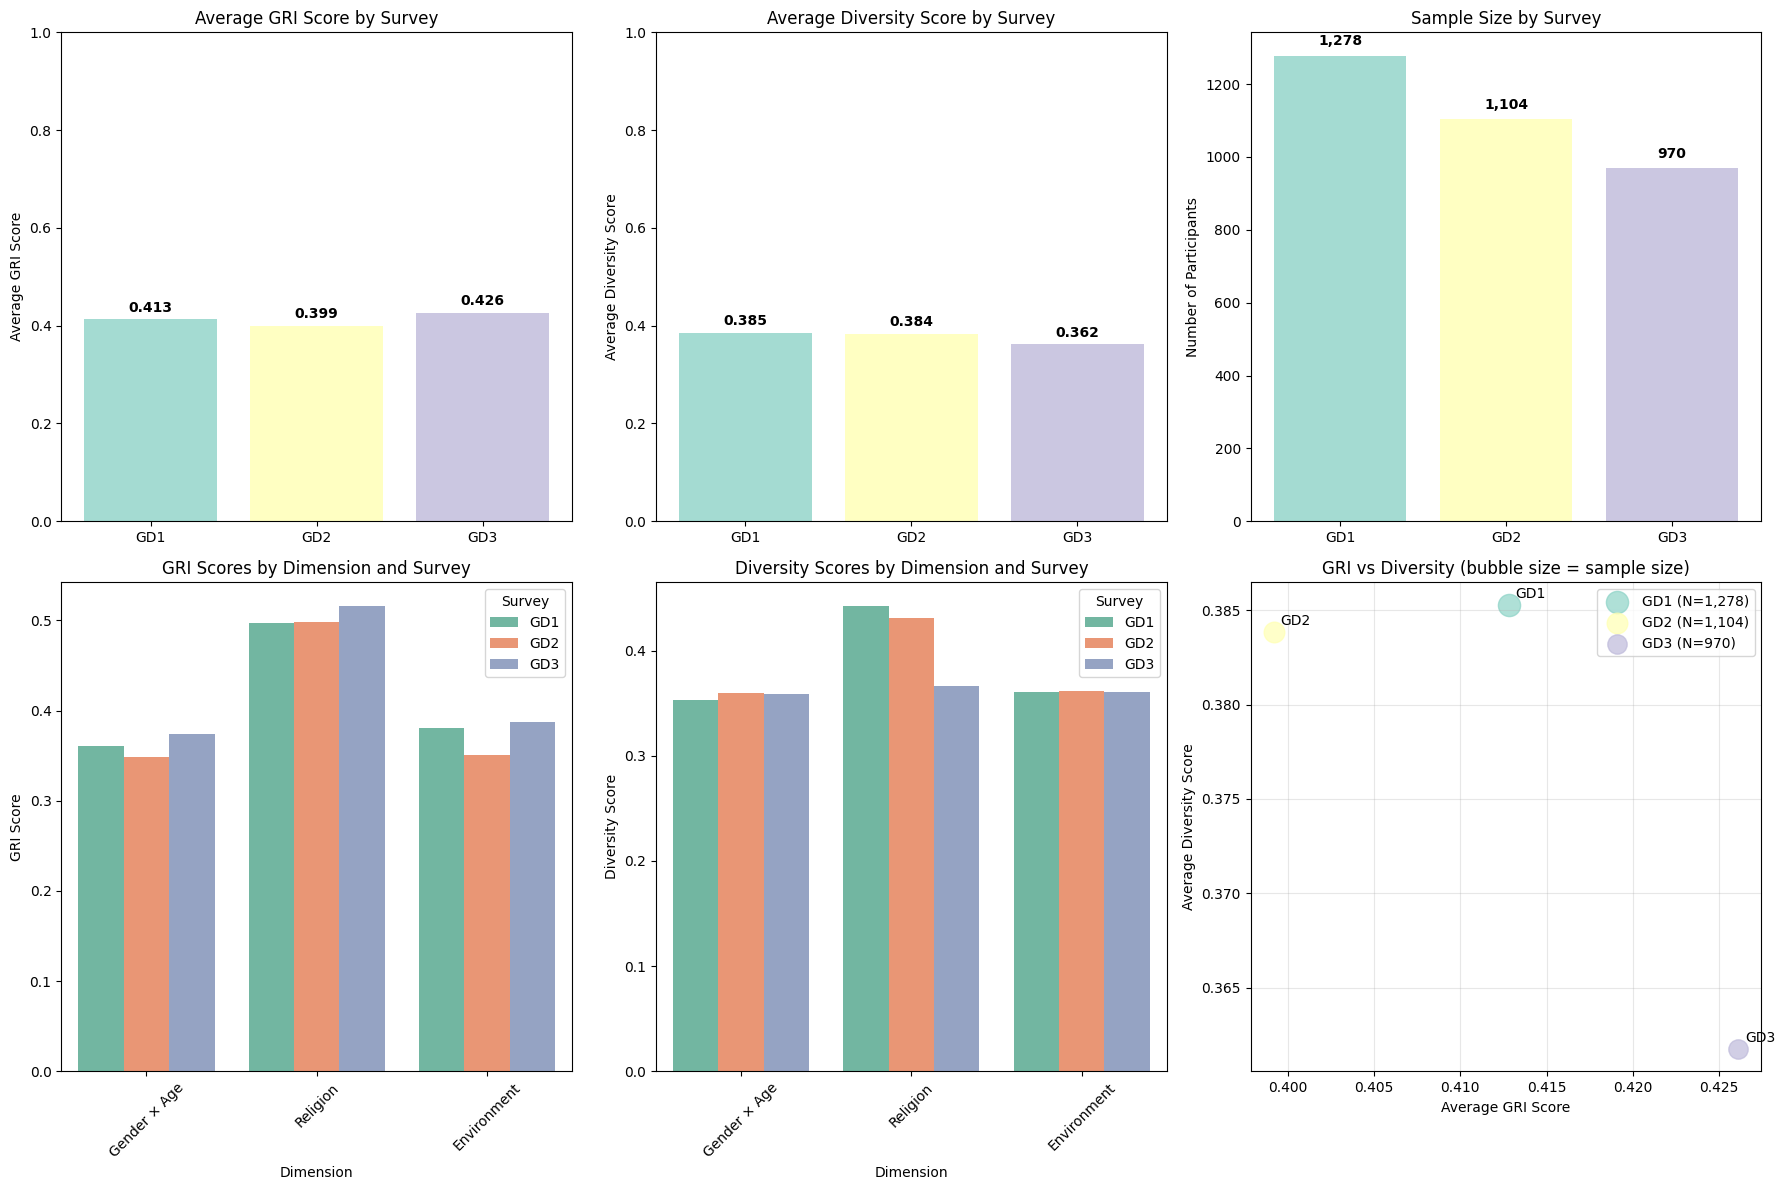

In [5]:
# Create comprehensive comparison visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Average GRI comparison
bars1 = axes[0,0].bar(comparison_df['survey'], comparison_df['average_gri'], 
                     color=['#8dd3c7', '#ffffb3', '#bebada'], alpha=0.8)
axes[0,0].set_title('Average GRI Score by Survey')
axes[0,0].set_ylabel('Average GRI Score')
axes[0,0].set_ylim(0, 1)
# Add value labels
for bar, value in zip(bars1, comparison_df['average_gri']):
    axes[0,0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                  f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Average Diversity comparison
bars2 = axes[0,1].bar(comparison_df['survey'], comparison_df['average_diversity'],
                     color=['#8dd3c7', '#ffffb3', '#bebada'], alpha=0.8)
axes[0,1].set_title('Average Diversity Score by Survey')
axes[0,1].set_ylabel('Average Diversity Score')
axes[0,1].set_ylim(0, 1)
# Add value labels
for bar, value in zip(bars2, comparison_df['average_diversity']):
    axes[0,1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                  f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Sample size comparison
bars3 = axes[0,2].bar(comparison_df['survey'], comparison_df['participants'],
                     color=['#8dd3c7', '#ffffb3', '#bebada'], alpha=0.8)
axes[0,2].set_title('Sample Size by Survey')
axes[0,2].set_ylabel('Number of Participants')
# Add value labels
for bar, value in zip(bars3, comparison_df['participants']):
    axes[0,2].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 20,
                  f'{value:,}', ha='center', va='bottom', fontweight='bold')

# 4. GRI scores by dimension
gri_dims = comparison_df[['survey', 'gri_gender_age', 'gri_religion', 'gri_environment']]
gri_dims_melted = gri_dims.melt(id_vars=['survey'], var_name='dimension', value_name='gri_score')
gri_dims_melted['dimension'] = gri_dims_melted['dimension'].str.replace('gri_', '').str.replace('_', ' × ').str.title()

import seaborn as sns
sns.barplot(data=gri_dims_melted, x='dimension', y='gri_score', hue='survey', ax=axes[1,0])
axes[1,0].set_title('GRI Scores by Dimension and Survey')
axes[1,0].set_ylabel('GRI Score')
axes[1,0].set_xlabel('Dimension')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].legend(title='Survey')

# 5. Diversity scores by dimension
div_dims = comparison_df[['survey', 'diversity_gender_age', 'diversity_religion', 'diversity_environment']]
div_dims_melted = div_dims.melt(id_vars=['survey'], var_name='dimension', value_name='diversity_score')
div_dims_melted['dimension'] = div_dims_melted['dimension'].str.replace('diversity_', '').str.replace('_', ' × ').str.title()

sns.barplot(data=div_dims_melted, x='dimension', y='diversity_score', hue='survey', ax=axes[1,1])
axes[1,1].set_title('Diversity Scores by Dimension and Survey')
axes[1,1].set_ylabel('Diversity Score')
axes[1,1].set_xlabel('Dimension')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend(title='Survey')

# 6. GRI vs Diversity scatter plot
colors = ['#8dd3c7', '#ffffb3', '#bebada']
for i, (_, row) in enumerate(comparison_df.iterrows()):
    axes[1,2].scatter(row['average_gri'], row['average_diversity'], 
                     s=row['participants']/5, c=colors[i], alpha=0.7, 
                     label=f"{row['survey']} (N={row['participants']:,})")
    axes[1,2].annotate(row['survey'], 
                      (row['average_gri'], row['average_diversity']),
                      xytext=(5, 5), textcoords='offset points', fontsize=10)

axes[1,2].set_xlabel('Average GRI Score')
axes[1,2].set_ylabel('Average Diversity Score')
axes[1,2].set_title('GRI vs Diversity (bubble size = sample size)')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Trend Analysis and Insights

In [6]:
# Analyze trends across survey iterations
print("TREND ANALYSIS: GLOBAL DIALOGUES EVOLUTION")
print("=" * 60)

# Calculate changes between surveys
gd1_gri = comparison_df[comparison_df['survey'] == 'GD1']['average_gri'].iloc[0]
gd2_gri = comparison_df[comparison_df['survey'] == 'GD2']['average_gri'].iloc[0]
gd3_gri = comparison_df[comparison_df['survey'] == 'GD3']['average_gri'].iloc[0]

gd1_div = comparison_df[comparison_df['survey'] == 'GD1']['average_diversity'].iloc[0]
gd2_div = comparison_df[comparison_df['survey'] == 'GD2']['average_diversity'].iloc[0]
gd3_div = comparison_df[comparison_df['survey'] == 'GD3']['average_diversity'].iloc[0]

print(f"\n📈 GRI EVOLUTION:")
print(f"  GD1 → GD2: {gd1_gri:.4f} → {gd2_gri:.4f} ({gd2_gri - gd1_gri:+.4f})")
print(f"  GD2 → GD3: {gd2_gri:.4f} → {gd3_gri:.4f} ({gd3_gri - gd2_gri:+.4f})")
print(f"  Overall GD1 → GD3: {gd1_gri:.4f} → {gd3_gri:.4f} ({gd3_gri - gd1_gri:+.4f})")

print(f"\n📊 DIVERSITY EVOLUTION:")
print(f"  GD1 → GD2: {gd1_div:.4f} → {gd2_div:.4f} ({gd2_div - gd1_div:+.4f})")
print(f"  GD2 → GD3: {gd2_div:.4f} → {gd3_div:.4f} ({gd3_div - gd2_div:+.4f})")
print(f"  Overall GD1 → GD3: {gd1_div:.4f} → {gd3_div:.4f} ({gd3_div - gd1_div:+.4f})")

# Best performing dimensions
print(f"\n🏆 BEST PERFORMING DIMENSIONS:")
best_gri_by_dim = {}
for dim in ['gender_age', 'religion', 'environment']:
    dim_scores = comparison_df[f'gri_{dim}'].values
    best_survey_idx = np.argmax(dim_scores)
    best_survey = comparison_df.iloc[best_survey_idx]['survey']
    best_score = dim_scores[best_survey_idx]
    dim_name = dim.replace('_', ' × ').title()
    print(f"  {dim_name}: {best_survey} ({best_score:.4f})")
    best_gri_by_dim[dim] = (best_survey, best_score)

# Sample size efficiency
print(f"\n📏 SAMPLE SIZE EFFICIENCY (GRI per 100 participants):")
for _, row in comparison_df.iterrows():
    efficiency = (row['average_gri'] / row['participants']) * 100
    print(f"  {row['survey']}: {efficiency:.6f} (GRI: {row['average_gri']:.4f}, N: {row['participants']:,})")

# Recommendations
print(f"\n💡 INSIGHTS AND RECOMMENDATIONS:")
print(f"")
best_overall = comparison_df.loc[comparison_df['average_gri'].idxmax()]
print(f"1. Best Overall Performance: {best_overall['survey']} with {best_overall['average_gri']:.4f} average GRI")

if gd3_gri > gd1_gri:
    print(f"2. ✅ Positive Trend: GRI improved from GD1 to GD3 by {gd3_gri - gd1_gri:.4f} points")
else:
    print(f"2. ⚠️  Declining Trend: GRI decreased from GD1 to GD3 by {abs(gd3_gri - gd1_gri):.4f} points")

# Find dimension with most consistent performance
dim_consistency = {}
for dim in ['gender_age', 'religion', 'environment']:
    scores = comparison_df[f'gri_{dim}'].values
    dim_consistency[dim] = np.std(scores)

most_consistent = min(dim_consistency.keys(), key=lambda x: dim_consistency[x])
least_consistent = max(dim_consistency.keys(), key=lambda x: dim_consistency[x])

print(f"3. Most Consistent Dimension: {most_consistent.replace('_', ' × ').title()} (std: {dim_consistency[most_consistent]:.4f})")
print(f"4. Most Variable Dimension: {least_consistent.replace('_', ' × ').title()} (std: {dim_consistency[least_consistent]:.4f})")

# Sample size recommendations
best_efficiency = comparison_df.loc[comparison_df.apply(lambda x: x['average_gri']/x['participants'], axis=1).idxmax()]
print(f"5. Most Efficient Survey: {best_efficiency['survey']} achieved highest GRI per participant")

TREND ANALYSIS: GLOBAL DIALOGUES EVOLUTION

📈 GRI EVOLUTION:
  GD1 → GD2: 0.4128 → 0.3992 (-0.0136)
  GD2 → GD3: 0.3992 → 0.4261 (+0.0269)
  Overall GD1 → GD3: 0.4128 → 0.4261 (+0.0133)

📊 DIVERSITY EVOLUTION:
  GD1 → GD2: 0.3853 → 0.3838 (-0.0015)
  GD2 → GD3: 0.3838 → 0.3617 (-0.0221)
  Overall GD1 → GD3: 0.3853 → 0.3617 (-0.0236)

🏆 BEST PERFORMING DIMENSIONS:
  Gender × Age: GD3 (0.3746)
  Religion: GD3 (0.5165)
  Environment: GD3 (0.3872)

📏 SAMPLE SIZE EFFICIENCY (GRI per 100 participants):
  GD1: 0.032300 (GRI: 0.4128, N: 1,278)
  GD2: 0.036159 (GRI: 0.3992, N: 1,104)
  GD3: 0.043929 (GRI: 0.4261, N: 970)

💡 INSIGHTS AND RECOMMENDATIONS:

1. Best Overall Performance: GD3 with 0.4261 average GRI
2. ✅ Positive Trend: GRI improved from GD1 to GD3 by 0.0133 points
3. Most Consistent Dimension: Religion (std: 0.0090)
4. Most Variable Dimension: Environment (std: 0.0158)
5. Most Efficient Survey: GD3 achieved highest GRI per participant


## 5. Save Comparison Results

In [7]:
# Save comparison results
output_dir = '../analysis_output'
os.makedirs(output_dir, exist_ok=True)

# Save detailed comparison table
comparison_file = f'{output_dir}/gd_survey_comparison.csv'
comparison_df.to_csv(comparison_file, index=False)

# Save summary statistics
summary_stats = {
    'survey_count': len(comparison_df),
    'total_participants': int(comparison_df['participants'].sum()),
    'average_gri_across_surveys': float(comparison_df['average_gri'].mean()),
    'average_diversity_across_surveys': float(comparison_df['average_diversity'].mean()),
    'best_gri_survey': comparison_df.loc[comparison_df['average_gri'].idxmax(), 'survey'],
    'best_gri_score': float(comparison_df['average_gri'].max()),
    'best_diversity_survey': comparison_df.loc[comparison_df['average_diversity'].idxmax(), 'survey'],
    'best_diversity_score': float(comparison_df['average_diversity'].max()),
    'gri_improvement_gd1_to_gd3': float(gd3_gri - gd1_gri),
    'diversity_improvement_gd1_to_gd3': float(gd3_div - gd1_div)
}

summary_file = f'{output_dir}/gd_survey_comparison_summary.json'
with open(summary_file, 'w') as f:
    json.dump(summary_stats, f, indent=2)

print("Results saved:")
print(f"  - {comparison_file}")
print(f"  - {summary_file}")
print(f"\nComparison analysis complete! 🎉")
print(f"\nKey Finding: {summary_stats['best_gri_survey']} performed best with {summary_stats['best_gri_score']:.4f} average GRI")

Results saved:
  - ../analysis_output/gd_survey_comparison.csv
  - ../analysis_output/gd_survey_comparison_summary.json

Comparison analysis complete! 🎉

Key Finding: GD3 performed best with 0.4261 average GRI


## Summary

This notebook provides a comprehensive comparison of GRI performance across Global Dialogues surveys:

1. ✅ **Data Loading**: Successfully loaded and processed GD1, GD2, and GD3 survey data
2. ✅ **Score Calculation**: Calculated GRI and Diversity scores across all dimensions for each survey
3. ✅ **Comparative Analysis**: Identified trends, best performers, and areas for improvement
4. ✅ **Visualization**: Created comprehensive charts showing relative performance
5. ✅ **Insights Generation**: Provided actionable recommendations for future survey design

**Key Insights:**
- Track GRI evolution across survey iterations
- Identify most and least consistent dimensions
- Understand sample size efficiency patterns
- Compare representativeness across different methodologies

**Next Steps:**
- Use insights to improve future Global Dialogues survey design
- Apply similar comparison methodology to other survey programs
- Consider implementing best practices from top-performing surveys